In [29]:
%matplotlib inline
from os.path import join
import pandas as pd
import skbio
import matplotlib.pyplot as plt
from skbio.stats import ordination
import seaborn as sns
import numpy as np
from itertools import chain


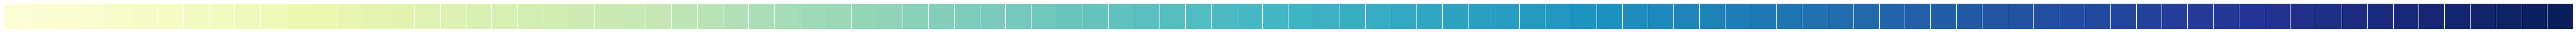

In [30]:
sns.palplot(sns.color_palette("YlGnBu", 100))
colors = sns.color_palette("YlGnBu", 100)

In [31]:
def filter_dm_and_map(dm, map_df):
    ids_to_exclude = set(dm.ids) - set(map_df.index.values)
    ids_to_keep = set(dm.ids) - ids_to_exclude
    filtered_dm = dm.filter(ids_to_keep)
    filtered_map = map_df.loc[ids_to_keep]

    return filtered_dm, filtered_map

def midpoint(x, y):
    return ((x[0] + x[1])/2, (y[0] + y[1])/2)

In [32]:
home = '/home/office-microbe-files'
map_fp = join(home, 'master_map_150908.txt')
sample_md = pd.read_csv(map_fp, sep='\t', index_col=0, dtype=str)
sample_md = sample_md[sample_md['16SITS'] == 'ITS']
sample_md = sample_md[sample_md['OfficeSample'] == 'yes']
sample_md['Meta'] = sample_md.ProjectID.apply(lambda x: '.'.join(x.split('.')[:3]))


In [33]:
w_dm = skbio.DistanceMatrix.read(join(home, '/home/johnchase/office-project/office-microbes/notebooks/UNITE-analysis/core_div/core_div_open/bdiv_even999/bray_curtis_dm.txt'))
u_dm = skbio.DistanceMatrix.read(join(home, '/home/johnchase/office-project/office-microbes/notebooks/UNITE-analysis/core_div/core_div_open/bdiv_even999/binary_jaccard_dm.txt'))

In [34]:
dist_mat = u_dm

In [35]:
alpha_div_fp = '/home/johnchase/office-project/office-microbes/notebooks/UNITE-analysis/core_div/core_div_open/arare_max999/alpha_div_collated/observed_species.txt'
alpha_div = pd.read_csv(alpha_div_fp, sep='\t', index_col=0)
alpha_div = alpha_div.T.drop(['sequences per sample', 'iteration'])
alpha_cols = [e for e in alpha_div.columns if '990' in e]
alpha_div = alpha_div[alpha_cols]

In [36]:
sample_md = pd.concat([sample_md, alpha_div], axis=1, join='inner')
sample_md['MeanAlpha'] = sample_md[alpha_cols].mean(axis=1)

#Plot all samples colored by run and season
##Filter out all replicates and blanks


In [37]:
replicate_ids = '''F2F.2.Ce.021
F2F.2.Ce.022
F2F.3.Ce.021
F2F.3.Ce.022
F2W.2.Ca.021
F2W.2.Ca.022
F2W.2.Ce.021
F2W.2.Ce.022
F3W.2.Ce.021
F3W.2.Ce.022
F1F.3.Ca.021
F1F.3.Ca.022
F1C.3.Ca.021
F1C.3.Ca.022
F1W.2.Ce.021
F1W.2.Ce.022
F1W.3.Dr.021
F1W.3.Dr.022
F1C.3.Dr.021
F1C.3.Dr.022
F2W.3.Dr.059
F3F.2.Ce.078'''.split('\n')

In [38]:
reps = sample_md[sample_md['Description'].isin(replicate_ids)]
reps = reps.drop(reps.drop_duplicates('Description').index).index
filt_md = sample_md.drop(reps, inplace=False)

Filter distance matrix and map to match each other

In [39]:
filt_dm, filt_md = filter_dm_and_map(dist_mat, filt_md)

Calculate pcoa

In [40]:
filt_pcoa = ordination.pcoa(filt_dm)

###add pcoa to mapping file

In [41]:
filt_md.loc[:, 'PC1'] = filt_pcoa.samples.loc[filt_md.index, 'PC1']
filt_md.loc[:, 'PC2'] = filt_pcoa.samples.loc[filt_md.index, 'PC2']
filt_md.loc[:, 'PC3'] = filt_pcoa.samples.loc[filt_md.index, 'PC3']

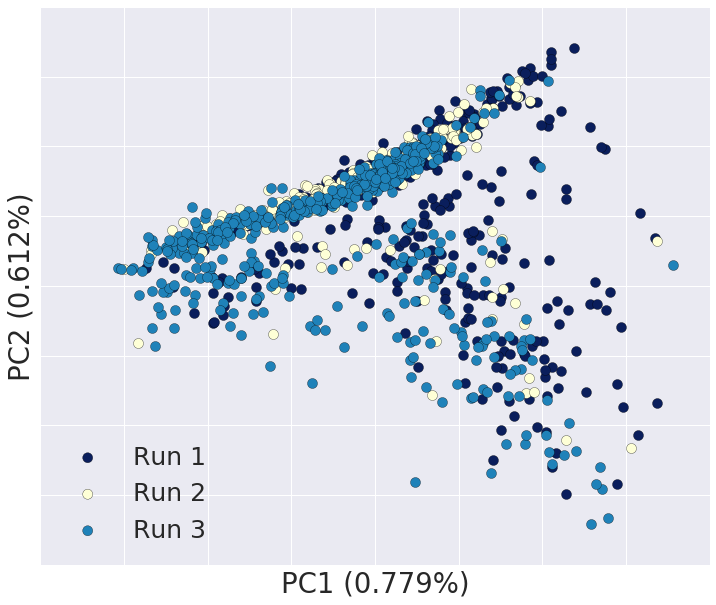

In [42]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2.5))):
    
    fig, ax = plt.subplots(1, 1)    
    fig.set_size_inches(12, 10)
    groups = filt_md.groupby('Run')
    vals = [99, 0, 66, 33]
    c = 0
    x = 'PC1'
    y = 'PC2'

    for name, group in groups:
        ax.scatter(group[x], group[y], label=name, c=colors[vals[c]], s=100)
        c += 1
    ax.legend(['Run 1', 'Run 2', 'Run 3'], loc='lower left')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    
    ax.set_xlabel('{pc} ({num:.{digits}f}%)'.format(pc=x, num=filt_pcoa.proportion_explained[x]*100, digits=3))
    ax.set_ylabel('{pc} ({num:.{digits}f}%)'.format(pc=y, num=filt_pcoa.proportion_explained[y]*100, digits=3))
    plt.savefig('its-all_samples_run_jaccard.svg', dpi=300)

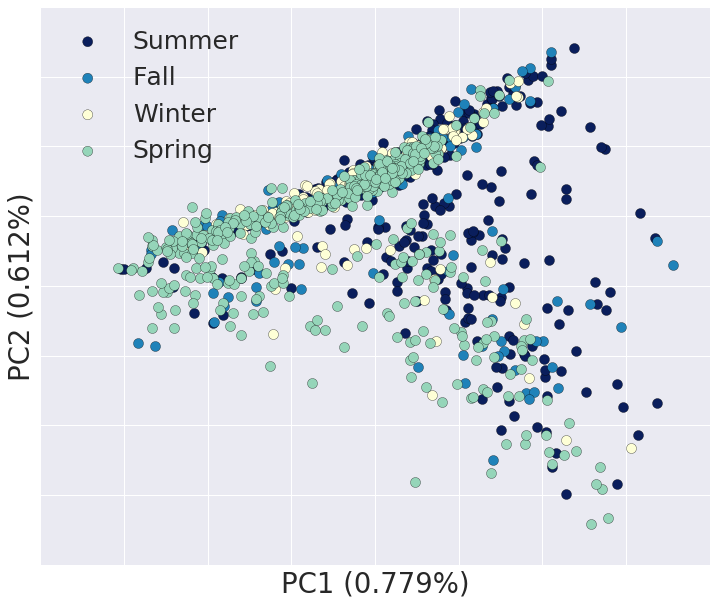

In [43]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2.5))):
    
    fig, ax = plt.subplots(1, 1)    
    fig.set_size_inches(12, 10)
    groups = filt_md.groupby('Period')
    vals = [99, 66, 0, 33]
    c = 0
    x = 'PC1'
    y = 'PC2'
    alphas = [1, 1, .3, 1]
    for name, group in groups:
        ax.scatter(group[x], group[y], label=name, c=colors[vals[c]], s=100)
        c += 1
    ax.legend(['Summer', 'Fall', 'Winter', 'Spring'], loc='upper left')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xlabel('{pc} ({num:.{digits}f}%)'.format(pc=x, num=filt_pcoa.proportion_explained[x]*100, digits=3))
    ax.set_ylabel('{pc} ({num:.{digits}f}%)'.format(pc=y, num=filt_pcoa.proportion_explained[y]*100, digits=3))
    plt.savefig('its-all_samples_season_jaccard.svg', dpi=300)

We need 4 pcoa plots

1. Plot all samples except for replicates and blanks colored by season
2. Plot all samples except for replicates and blanks colored by Run
3. Plot samples that were from the same season, but different runs. 
4. Plot different seasons but on the same runs.  

In [44]:
sample_id_replicates = []
for i in sample_md[sample_md.duplicated('ProjectID', keep=False)]['ProjectID']:
    runs = sorted(list(set(sample_md[sample_md['ProjectID'] == i]['Run'])))
    if runs == ['1', '2', '3']:
        sample_id_replicates.append(sample_md[sample_md['ProjectID'] == i].index.tolist())
        
sample_id_replicates = set(chain.from_iterable(sample_id_replicates))
replicate_md = sample_md.loc[sample_id_replicates].drop_duplicates(['ProjectID', 'Run']).sort_values(['ProjectID', 'Run'])

In [45]:
replicate_dm, replicate_md = filter_dm_and_map(u_dm, replicate_md)
replicate_pcoa = ordination.pcoa(replicate_dm)

In [46]:
replicate_md.loc[:, 'PC1'] = replicate_pcoa.samples.loc[replicate_md.index, 'PC1']
replicate_md.loc[:, 'PC2'] = replicate_pcoa.samples.loc[replicate_md.index, 'PC2']
replicate_md.loc[:, 'PC3'] = replicate_pcoa.samples.loc[replicate_md.index, 'PC3']

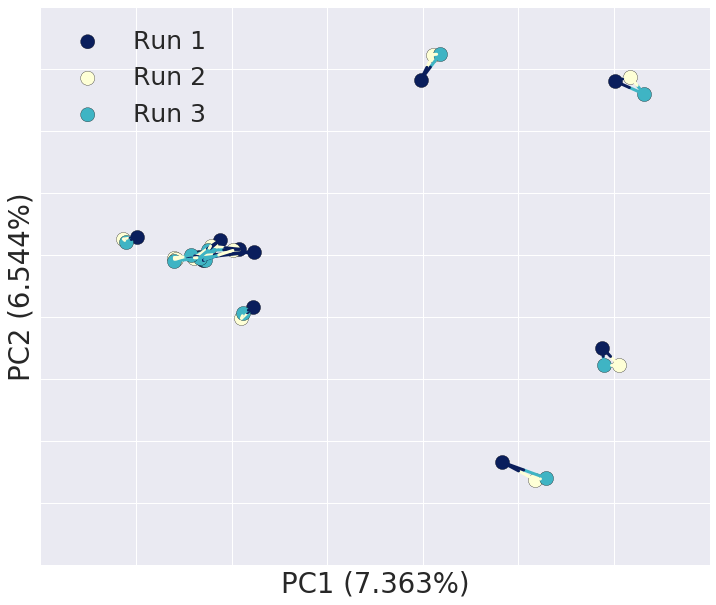

In [47]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2.5))):
    
    fig, ax = plt.subplots(1, 1)    
    fig.set_size_inches(12, 10)
    groups = replicate_md.groupby('Run')
    vals = [99, 0, 50, 33]
    c = 0
    x = 'PC1'
    y = 'PC2'
    for name, group in groups:
        ax.scatter(group[x], group[y], label=name, c=colors[vals[c]], s=200)
        c += 1
    ax.legend(['Run 1', 'Run 2', 'Run 3'], loc='best')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xlabel('{pc} ({num:.{digits}f}%)'.format(pc=x, num=replicate_pcoa.proportion_explained[x]*100, digits=3))
    ax.set_ylabel('{pc} ({num:.{digits}f}%)'.format(pc=y, num=replicate_pcoa.proportion_explained[y]*100, digits=3))
    
    for id_ in replicate_md.ProjectID.unique():
        x3, y3 = replicate_md[(replicate_md.ProjectID == id_) & (replicate_md.Run == '1')][[x, y]].values[0]
        x1, y1 = replicate_md[(replicate_md.ProjectID == id_) & (replicate_md.Run == '2')][[x, y]].values[0]
        x2, y2 = midpoint([x1, x3], [y1, y3])
        ax.plot([x1, x2], [y1, y2], c=colors[0], linewidth=3.0)
        ax.plot([x2, x3], [y2, y3], c=colors[99], linewidth=3.0)
        
    for id_ in replicate_md.ProjectID.unique():
        x3, y3 = replicate_md[(replicate_md.ProjectID == id_) & (replicate_md.Run == '1')][[x, y]].values[0]
        x1, y1 = replicate_md[(replicate_md.ProjectID == id_) & (replicate_md.Run == '3')][[x, y]].values[0]
        x2, y2 = midpoint([x1, x3], [y1, y3])
        ax.plot([x1, x2], [y1, y2], c=colors[50], linewidth=3.0)
        ax.plot([x2, x3], [y2, y3], c=colors[99], linewidth=3.0)

    for id_ in replicate_md.ProjectID.unique():
        x3, y3 = replicate_md[(replicate_md.ProjectID == id_) & (replicate_md.Run == '2')][[x, y]].values[0]
        x1, y1 = replicate_md[(replicate_md.ProjectID == id_) & (replicate_md.Run == '3')][[x, y]].values[0]
        x2, y2 = midpoint([x1, x3], [y1, y3])
        ax.plot([x1, x2], [y1, y2], c=colors[50], linewidth=3.0)
        ax.plot([x2, x3], [y2, y3], c=colors[0], linewidth=3.0)
plt.savefig('its-reps_samples_run_jaccard.svg', dpi=300)


In [48]:
run_3_dups = sample_md[(sample_md['Run'] == '3') & (sample_md['Period'] != '4')]
run_3_dups = run_3_dups[run_3_dups.duplicated('Meta', keep=False)]

In [49]:
run_3_dups_dm, run_3_dups = filter_dm_and_map(dist_mat, run_3_dups)
run_3_dups_pcoa = ordination.pcoa(run_3_dups_dm)

In [50]:
run_3_dups.loc[:, 'PC1'] = run_3_dups_pcoa.samples.loc[run_3_dups.index, 'PC1']
run_3_dups.loc[:, 'PC2'] = run_3_dups_pcoa.samples.loc[run_3_dups.index, 'PC2']
run_3_dups.loc[:, 'PC3'] = run_3_dups_pcoa.samples.loc[run_3_dups.index, 'PC3']

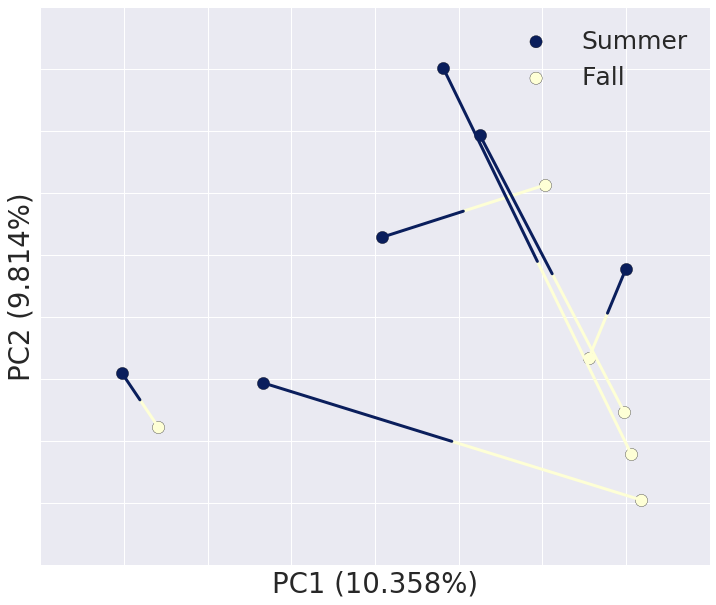

In [51]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2.5))):
    
    fig, ax = plt.subplots(1, 1)    
    fig.set_size_inches(12, 10)
    groups = run_3_dups.groupby('Period')
    vals = [99, 0, 0, 33]
    c = 0
    x = 'PC1'
    y = 'PC2'
    for name, group in groups:
        ax.scatter(group[x], group[y], label=name, c=colors[vals[c]], s=150)
        c += 1
    ax.legend(['Summer', 'Fall'], loc='best')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xlabel('{pc} ({num:.{digits}f}%)'.format(pc=x, num=run_3_dups_pcoa.proportion_explained[x]*100, digits=3))
    ax.set_ylabel('{pc} ({num:.{digits}f}%)'.format(pc=y, num=run_3_dups_pcoa.proportion_explained[y]*100, digits=3))
    
#To get rid of lines just comment the next few lines out    
    for id_ in run_3_dups.Description.apply(lambda x: '.'.join(x.split('.')[:3])).unique():
        x3, y3 = run_3_dups[(run_3_dups.Meta == id_) & (run_3_dups.Period == '1')][[x, y]].values[0]
        x1, y1 = run_3_dups[(run_3_dups.Meta == id_) & (run_3_dups.Period == '2')][[x, y]].values[0]
        x2, y2 = midpoint([x1, x3], [y1, y3])
        ax.plot([x1, x2], [y1, y2], c=colors[0], linewidth=3.0)
        ax.plot([x2, x3], [y2, y3], c=colors[99], linewidth=3.0)
plt.savefig('its-reps_samples_season_jaccard.svg', dpi=300)


#Alpha diversity plots

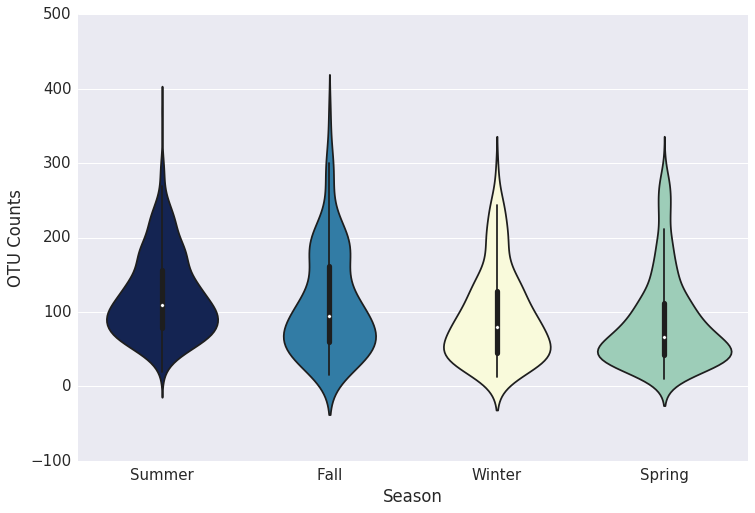

In [52]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=1.5))):
    plt.figure(figsize=(12, 8))
    ax = sns.violinplot(x="Period", y="MeanAlpha", data=filt_md.sort_values("Period"), palette= [colors[e] for e in [99, 66, 0, 33]])
    ax.set_xticklabels(['Summer', 'Fall', 'Winter', 'Spring'])
    ax.set_xlabel('Season')
    ax.set_ylabel('OTU Counts')
plt.savefig('its-all_samples_season_diversity.svg', dpi=300)



/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/IPython/kernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


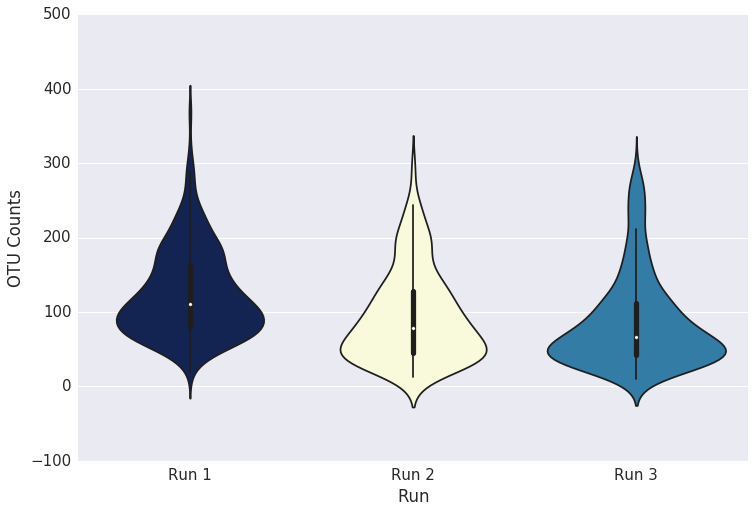

In [53]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=1.5))):
    plt.figure(figsize=(12, 8))
    ax = sns.violinplot(x="Run", y="MeanAlpha", data=filt_md.sort("Run"), palette= [colors[e] for e in [99, 0, 66]])
    ax.set_xticklabels(['Run 1', 'Run 2', 'Run 3'])
    ax.set_ylabel('OTU Counts')
plt.savefig('its-all_samples_run_diversity.svg', dpi=300)


/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/IPython/kernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


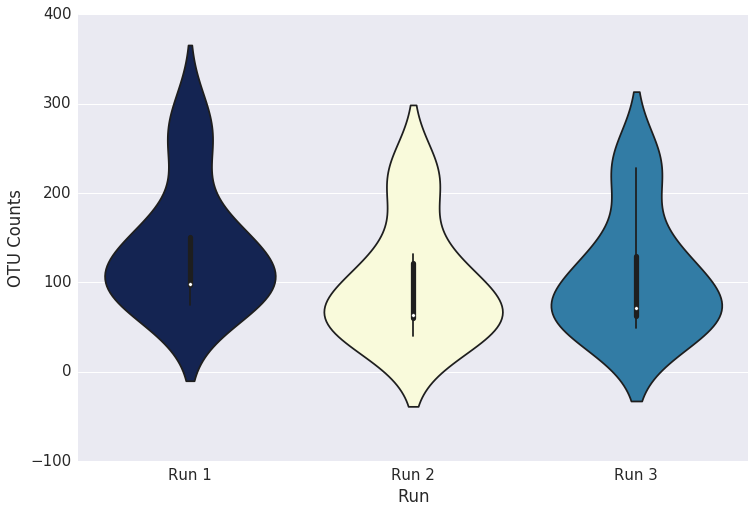

In [54]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=1.5))):
    plt.figure(figsize=(12, 8))
    ax = sns.violinplot(x="Run", y="MeanAlpha", data=replicate_md.sort("Period"), palette= [colors[e] for e in [99, 0, 66]])
    ax.set_xticklabels(['Run 1', 'Run 2', 'Run 3'])
    ax.set_ylabel('OTU Counts')
plt.savefig('its-reps_samples_run_diversity.svg', dpi=300)


/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/IPython/kernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


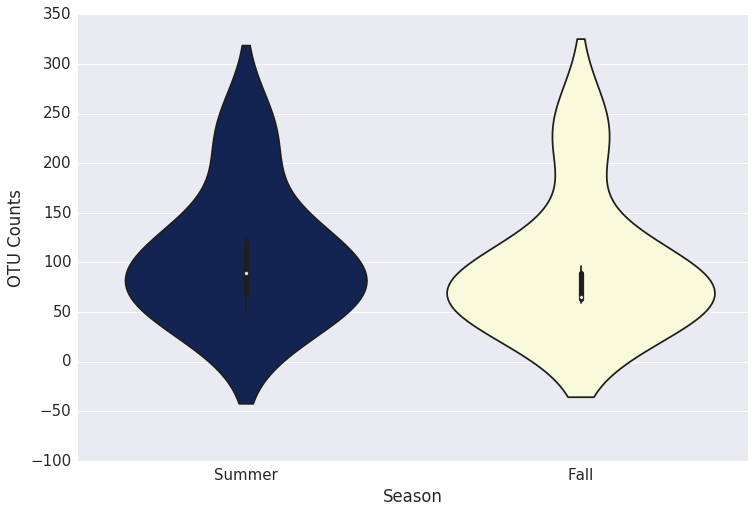

In [55]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=1.5))):
    plt.figure(figsize=(12, 8))
    ax = sns.violinplot(x="Period", y="MeanAlpha", data=run_3_dups.sort("Period"), palette= [colors[e] for e in [99, 0]])
    ax.set_xticklabels(['Summer', 'Fall'])
    ax.set_xlabel('Season')
    ax.set_ylabel('OTU Counts')
plt.savefig('its-reps_samples_season_diversity.svg', dpi=300)